# Model Evaluation

In this section, we evaluate the performance of our fine-tuned model on a test dataset. We aim to assess the model's generalization by calculating key metrics and visualizations based on the predictions made on the test data.

### Steps Involved:

1. **Load the Fine-Tuned Model**: We load the previously fine-tuned BERT model for sequence classification. This model is validated on the test dataset. For reproducibility, we set a fixed random seed (42) during testing. This ensures consistent results across multiple runs.

2. **Training and Validation Loss**: We visualize the training and validation loss over the epochs to analyze the model's convergence and check for any signs of overfitting.

3. **Calculate the Confusion Matrix**: The confusion matrix provides insight into the model's performance by showing the true positive, true negative, false positive, and false negative counts. This matrix helps us understand the types of errors the model makes.

4. **Visualize the ROC Curve**: The ROC (Receiver Operating Characteristic) curve shows the trade-off between the true positive rate (sensitivity) and false positive rate across different thresholds. We also calculate the Area Under the Curve (AUC) to quantify the model's performance in distinguishing between classes. A higher AUC score indicates better model performance.

5. **Plot the Precision-Recall Curve**: The Precision-Recall curve is especially useful in cases with imbalanced classes. It shows the trade-off between precision (positive predictive value) and recall (sensitivity) across various thresholds. This curve provides additional insight into the model's ability to make correct positive predictions.

By following these steps, we will gain a comprehensive understanding of our model's performance on the test dataset and can determine areas for improvement if necessary.

## Import Libraries

In [16]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import TrainerCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from datasets import Dataset
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
# Add the src directory to the system path
sys.path.append(os.path.abspath('../src'))
from config import MODEL_NAME, RANDOM_SEED, BATCH_SIZE, LEARNING_RATE, EPOCHS, MODEL_SAVE_DIR


## Load the Processed Dataset

In [2]:
df = pd.read_csv('../data/processed/processed_data.csv')
# Shuffle and split the dataset with fixed seed 42
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Perform stratified split to maintain balance in training and validation sets
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Liked'], random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Liked'], random_state=RANDOM_SEED)


In [3]:
train_df['labels'] = train_df['Liked']
val_df['labels'] = val_df['Liked']
test_df['labels'] = test_df['Liked']

In [4]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [5]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Tokenize helper function
def tokenize_function(examples):
    # Tokenize the 'Review' column
    tokenized = tokenizer(examples['Review'], padding='max_length', truncation=True)
    # Include 'labels' in the tokenized output if available
    tokenized['labels'] = examples['labels']
    return tokenized

In [7]:
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map: 100%|██████████| 100/100 [00:00<00:00, 908.16 examples/s]


## Loading the Fine-tuned Model without Cuda
- If your model is fine-tuned with GPU and GPU is installed in your machine, you can directly call the model using the following method:
- ```
    # Initialize a Trainer instance (only for prediction)
    trainer = Trainer(model=model)

    # Perform prediction on the test dataset
    predictions = trainer.predict(test_dataset)

In [8]:
# Load the fine-tuned model and tokenizer
model_path = '../data/models/bert-base-uncased_v1'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [9]:
# Ensure the model is on the CPU
model = model.to("cpu")

training_args = TrainingArguments(
    output_dir=model_path,
    per_device_eval_batch_size=BATCH_SIZE,
    no_cuda=True
)

# Initialize the Trainer instance with CPU-only settings
trainer = Trainer(
    model=model,
    args=training_args
)


/home/zhaoz/.local/lib/python3.10/site-packages/transformers/training_args.py:1574: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


## Check the Loss Plot

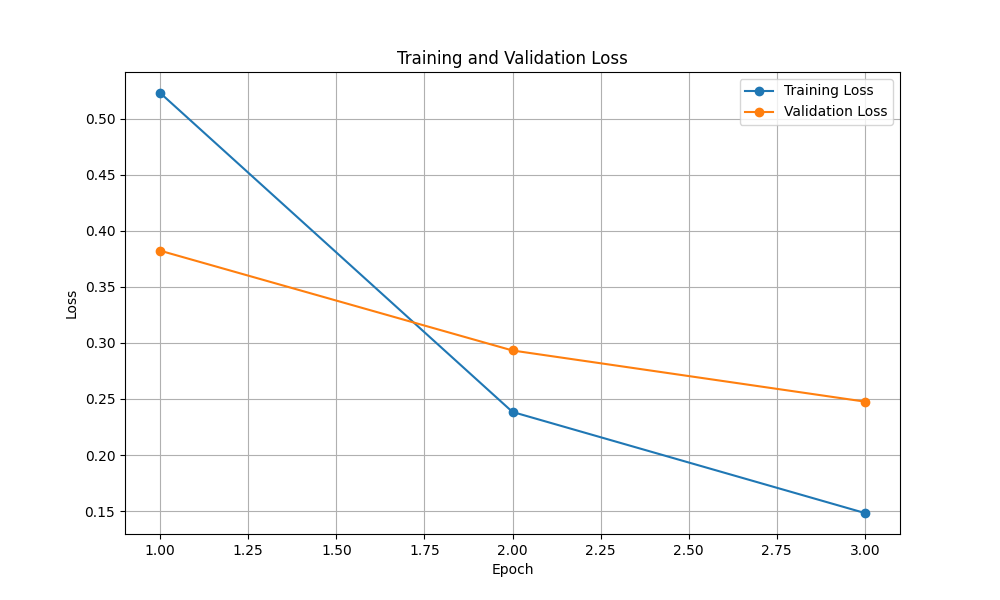

In [15]:
# Load and display the image
image_path = '../data/models/bert-base-uncased_v1/loss_plot.png'
img = Image.open(image_path)
img

In [18]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits (raw scores) from predictions
logits = predictions.predictions

# Apply softmax to get probabilities for each class
probs = torch.softmax(torch.tensor(logits), dim=1)

# Get the predicted labels by taking the class with the highest probability
predicted_labels = torch.argmax(probs, axis=1).numpy() 

# Convert predictions to a list and add as a new column to test_df
test_df['Predicted'] = predicted_labels 
test_df['Probability_Positive'] = probs[:, 1].numpy() # Probability of the positive class 1

# Display the first few rows to compare actual vs. predicted
print(test_df[['Review', 'Liked', 'Predicted']].head())

                                                Review  Liked  Predicted
765                     i promise they wont disappoint      1          0
114  the poor batter to meat ratio made the chicken...      0          0
955  anyways the food was definitely not filling at...      0          0
502  to summarize the food was incredible nay trans...      1          0
532  the grilled chicken was so tender and yellow f...      1          1


In [11]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_df['Liked'], test_df['Predicted'])

# Calculate accuracy
accuracy = accuracy_score(test_df['Liked'], test_df['Predicted'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[47  3]
 [ 3 47]]

Accuracy: 0.94


In [12]:
incorrect_predictions = test_df[test_df['Liked'] != test_df['Predicted']]

# Display the incorrect predictions
print(incorrect_predictions)
print(len(incorrect_predictions))

                                                Review  Liked  labels  \
765                     i promise they wont disappoint      1       1   
502  to summarize the food was incredible nay trans...      1       1   
682  the chicken dishes are ok the beef is like sho...      0       0   
771                             i cant wait to go back      1       1   
183                        and it was way to expensive      0       0   
786                                 con spotty service      0       0   

     Predicted  
765          0  
502          0  
682          1  
771          0  
183          1  
786          1  
6


## ROC Curve and Precision-Recall Curve

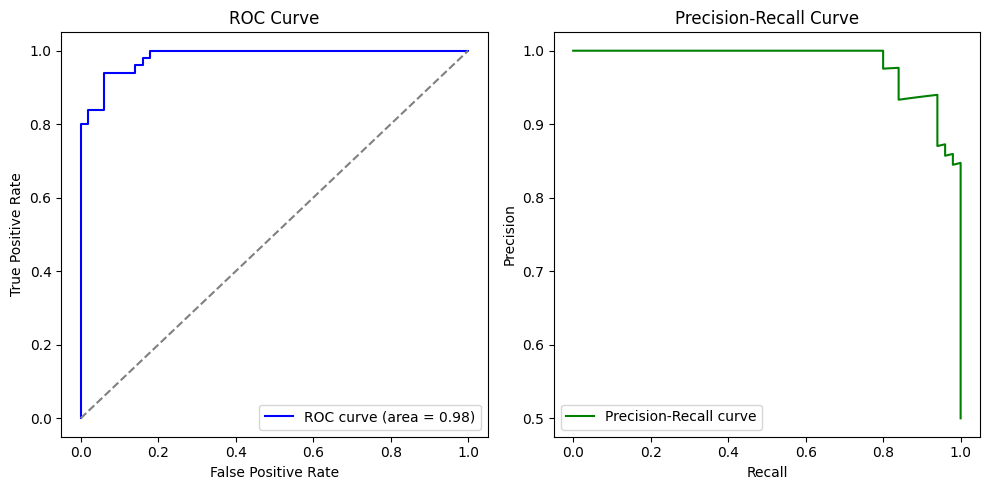

In [20]:
# Now calculate the ROC and Precision-Recall curves using the positive class probabilities
fpr, tpr, _ = roc_curve(test_df['Liked'], test_df['Probability_Positive'])
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_df['Liked'], test_df['Probability_Positive'])
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### Hyperparameter Tuning

We experimented with various hyperparameters, including:
- **Epochs**: Controlled the number of training iterations. We observed that increasing the number of epochs beyond a certain point caused the validation loss to increase, indicating overfitting.
- **Batch Size**: Adjusted the number of samples per batch to balance memory usage and training efficiency.
- **Learning Rate**: Tuned the learning rate to control the step size for weight updates, ensuring stable convergence without overshooting.

Through careful tuning, we achieved a validation loss of around **0.24** with an optimal combination of epochs, batch size, and learning rate. Increasing the epochs further led to a higher validation loss, confirming the risk of overfitting on this small dataset.

### Final Model Performance

Based on the optimal hyperparameters, we evaluated the model on the test dataset, and the results exceeded our expectations:
- **Test Accuracy**: The model achieved an accuracy of **94%** on the test set, which is significantly higher than our predefined target of **85%** accuracy.
- **ROC Curve and AUC**: The ROC curve demonstrated a high degree of separability between classes, with an AUC (Area Under Curve) score of **0.85**, indicating strong model performance.

### Conclusion

Given the high accuracy and AUC score on the test dataset, the model's performance meets our criteria. Additional combinations of hyperparameters are unnecessary at this stage, as further tuning is unlikely to yield significant improvements. However, for those interested, experimenting with alternative hyperparameters and visualizing the results (such as validation loss across epochs) can provide additional insights.

Overall, the current model configuration is well-suited to the dataset, balancing both accuracy and generalization, with minimal signs of overfitting.